In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint, odeint_adjoint

In [247]:
import torch.nn as nn
from torchdiffeq import odeint_adjoint

class ODEfunc(nn.Module):
    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.dim = dim
        self.mid_dim = 40
        self.seq = nn.Sequential(
            nn.Linear(dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, dim),
            # nn.Tanh()
        )

    def forward(self, t, x):
        return self.seq(x)


class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x, t):
        # integration_time = self.integration_time.type_as(x)
        
        out = odeint_adjoint(self.odefunc, x, t.reshape(-1), rtol=1e-4, atol=1e-4)
        return out


In [248]:
class ODEnet(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim):
        super(ODEnet, self).__init__()

        odefunc = ODEfunc(dim=mid_dim)
        
        self.fc1 = nn.Linear(in_dim, mid_dim)
        self.relu1 = nn.ReLU(inplace=True)
        self.norm1 = nn.BatchNorm1d(mid_dim)
        self.ode_block = ODEBlock(odefunc)  #Use ODE Block
        self.norm2 = nn.BatchNorm1d(mid_dim)
        self.fc2 = nn.Linear(mid_dim, out_dim)

        # count the number of parameters
        print("Number of parameters:", sum([p.numel() for p in self.parameters()]))

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.norm1(out)
        out = self.ode_block(out, torch.flatten(x))
        # print(out.shape)
        # print(out)
        out = self.norm2(out)
        out = self.fc2(out)

        return out

class ODEnetSimple(nn.Module):
    def __init__(self, out_dim):
        super(ODEnetSimple, self).__init__()

        odefunc = ODEfunc(dim=out_dim)
        
        self.ode_block = ODEBlock(odefunc)  #Use ODE Block
        # self.norm2 = nn.BatchNorm1d(mid_dim)
        # self.fc2 = nn.Linear(mid_dim, out_dim)

        # count the number of parameters
        print("Number of parameters:", sum([p.numel() for p in self.parameters()]))

    def forward(self, x, t):
        # print(x.shape)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        out = self.ode_block(x, torch.flatten(t))
        # print(out.shape)
        # print(out)
        # out = self.norm2(out)
        # out = self.fc2(out)

        return out


In [249]:
import numpy as np

class Ball:
    def __init__(self, x0, r, move_func):
        self.x0 = x0
        self.r = r
        self.x = x0
        self.t = 0
        self.move_func = move_func

    def step(self, dt):
        self.t += dt
        x = self.x
        self.x += dt*self.move_func(self.t, x)
        
        return self.x


def move_fun_circle(t, x, w=1, exp_decay=1.):
    return torch.exp(-torch.tensor(exp_decay*t))*torch.tensor([-w*np.sin(w*t), w*np.cos(w*t)], dtype=torch.float64)    


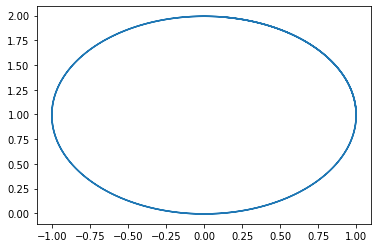

In [281]:
# create a ball and move it
N = 1000
dt = 1./N

ball = Ball(torch.tensor([1.,1.]), 1.,lambda t,x: move_fun_circle(t, x, w=14, exp_decay=0.))
positions = []
for i in range(N):
    # print(ball.x)
    positions.append(ball.x.numpy().copy())
    ball.step(dt)  

positions = np.stack(positions, axis=0)

# print(positions)
# display the positions in a plot 
plt.plot(positions[:,0], positions[:,1])
plt.show()

In [282]:
import torch.nn.functional as F
from tqdm.notebook import trange

class batchGetter:
    def __init__(self, batch_time, n_samples, total_length, dt, positions, N_train, noise=-1):
        self.times = torch.linspace(0., total_length*dt, total_length, dtype=torch.float64).float()
        self.true_positions = torch.tensor(positions, dtype=torch.float64).float()
        self.noise = noise

        if noise > 0 and noise < 1:
            # adding gaussian noise to the true positions
            self.true_positions = self.true_positions + torch.normal(0, noise, size=self.true_positions.shape)
            self.true_positions = self.true_positions.float()

        self.train_times = self.times[:N_train]
        self.test_times = self.times[N_train:]
        self.train_positions = self.true_positions[:N_train]
        self.test_positions = self.true_positions[N_train:]
        self.n_samples = n_samples
        self.batch_time = batch_time
        self.N_train = N_train
        self.dt = dt
        self.total_length = total_length

    def get_batch(self):
        sample = torch.randint(0, self.N_train, (self.n_samples,))
        batch_times = self.times[sample]
        batch_true_positions = self.train_positions[sample]
        return batch_times, batch_true_positions

# train our ODENet on the Ball motion

def train(model, optimizer, device, epochs, getter, display=100, all_data=False):
    model.train()
    iterator = trange(1, epochs+1)
    # just for the plot part
    

    for i in iterator:
        # get a random time sample
        if all_data:
            batch_times, batch_true_positions = getter.train_times, getter.train_positions
        else:    
            batch_times, batch_true_positions = getter.get_batch()
        # place the initial condition in the first position of the sample
        # integration_time = torch.tensor([torch.min(batch_times), torch.max(batch_times)]).float()
        # compute the output of the model
        out = model(batch_times.to(device))
        # compute the loss
        # print(out.shape, batch_true_positions.shape)
        loss = F.mse_loss(out, batch_true_positions.to(device))
        # compute the gradients
        optimizer.zero_grad()
        loss.backward()
        # update the parameters
        optimizer.step()
        # update the progress bar
        iterator.set_description_str(f'Loss: {loss.item():.4f}')

        if i % display == 0:
            # show the output
            predicted_output_train = model(getter.train_times.to(device))
            predicted_output_test = model(getter.test_times.to(device))
            # display in orange the predicted position and in blue the true position of the training set

            plt.plot(predicted_output_train[:,0].cpu().detach().numpy(), 
                    predicted_output_train[:,1].cpu().detach().numpy(), 'orange', label="Predicted train")
            
            plt.plot(predicted_output_test[:,0].cpu().detach().numpy(),
                    predicted_output_test[:,1].cpu().detach().numpy(), 'red', label="Predicted test")


            if getter.noise > 0 and getter.noise < 1:
                plt.scatter(getter.train_positions[:,0].cpu().detach().numpy(), 
                    getter.train_positions[:,1].cpu().detach().numpy(), s=1, c='b', label="True train")

                plt.scatter(getter.test_positions[:,0].cpu().detach().numpy(), 
                    getter.test_positions[:,1].cpu().detach().numpy(), s=1, c='cyan', label="True test")
            
            else:
                plt.plot(getter.train_positions[:,0].cpu().detach().numpy(), 
                    getter.train_positions[:,1].cpu().detach().numpy(), 'b', label="True train")

                plt.plot(getter.test_positions[:,0].cpu().detach().numpy(), 
                        getter.test_positions[:,1].cpu().detach().numpy(), 'cyan', label="True test")


            
            plt.legend()
            plt.show()
        
    return None

# get_random_time_sample(3, 10)
# torch.cat([torch.zeros(3,1), get_random_time_sample(3, 10)], dim=-1).float()


In [283]:
import torch.nn.functional as F
from tqdm.notebook import trange

class batchGetter:
    def __init__(self, batch_time, n_samples, total_length, dt, positions, N_train, noise=-1):
        self.times = torch.linspace(0., total_length*dt, total_length, dtype=torch.float64).float()
        self.true_positions = torch.tensor(positions, dtype=torch.float64).float()
        self.noise = noise

        if noise > 0 and noise < 1:
            # adding gaussian noise to the true positions
            self.true_positions = self.true_positions + torch.normal(0, noise, size=self.true_positions.shape)
            self.true_positions = self.true_positions.float()

        self.train_times = self.times[:N_train]
        self.test_times = self.times[N_train:]
        self.train_positions = self.true_positions[:N_train]
        self.test_positions = self.true_positions[N_train:]
        self.n_samples = n_samples
        self.batch_time = batch_time
        self.N_train = N_train
        self.dt = dt
        self.total_length = total_length

    def get_batch(self):
        s = torch.from_numpy(np.random.choice(np.arange(self.N_train - self.batch_time, dtype=np.int64), self.n_samples, replace=False))
        batch_y0 = self.train_positions[s]  # (M, D)
        batch_t = self.train_times[:self.batch_time]  # (T)
        batch_y = torch.stack([self.train_positions[s + i] for i in range(self.batch_time)], dim=0)  # (T, M, D)
        return batch_y0, batch_t, batch_y

# train our ODENet on the Ball motion

def train(model, optimizer, device, epochs, getter, display=100):
    
    model.train()
    iterator = trange(1, epochs+1)
    # just for the plot part
    for i in iterator:
        # get a random time sample
        
        batch_init_positions, batch_times, batch_true_positions = getter.get_batch()
        # place the initial condition in the first position of the sample
        # integration_time = torch.tensor([torch.min(batch_times), torch.max(batch_times)]).float()
        # compute the output of the model
        out = model(batch_init_positions, batch_times.to(device))
        # compute the loss
        # print(out.shape, batch_true_positions.shape)
        # print(out.shape, batch_true_positions.shape)
        # print(out[0], batch_true_positions[0])
        
        loss = F.mse_loss(out[-1].view(-1,2), batch_true_positions[-1].view(-1,2).to(device))
        # compute the gradients
        optimizer.zero_grad()
        loss.backward()
        # update the parameters
        optimizer.step()
        # update the progress bar
        iterator.set_description_str(f'Loss: {loss.item():.4f}')

        if i % display == 0:
            # show the output
            predicted_output_train = model(getter.train_positions.to(device),getter.train_times.to(device))
            predicted_output_test = model(getter.test_positions.to(device), getter.test_times.to(device))
            # display in orange the predicted position and in blue the true position of the training set

            plt.plot(predicted_output_train[:,-1,0].cpu().detach().numpy(), 
                    predicted_output_train[:,-1,1].cpu().detach().numpy(), 'orange', label="Predicted train")
            
            plt.plot(predicted_output_test[:,-1,0].cpu().detach().numpy(),
                    predicted_output_test[:,-1,1].cpu().detach().numpy(), 'red', label="Predicted test")


            if getter.noise > 0 and getter.noise < 1:
                plt.scatter(getter.train_positions[:,0].cpu().detach().numpy(), 
                    getter.train_positions[:,1].cpu().detach().numpy(), s=1, c='b', label="True train")

                plt.scatter(getter.test_positions[:,0].cpu().detach().numpy(), 
                    getter.test_positions[:,1].cpu().detach().numpy(), s=1, c='cyan', label="True test")
            
            else:
                plt.plot(getter.train_positions[:,0].cpu().detach().numpy(), 
                    getter.train_positions[:,1].cpu().detach().numpy(), 'b', label="True train")

                plt.plot(getter.test_positions[:,0].cpu().detach().numpy(), 
                        getter.test_positions[:,1].cpu().detach().numpy(), 'cyan', label="True test")


            
            plt.legend()
            plt.show()
        
    return None

# get_random_time_sample(3, 10)
# torch.cat([torch.zeros(3,1), get_random_time_sample(3, 10)], dim=-1).float()


In [284]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnetSimple(2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train the model

Number of parameters: 1842


In [ ]:
epochs = 1000
n_samples = 100
batch_time = 200
getter = batchGetter(batch_time=batch_time, n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=700, noise=-1)
losses = train(model, optimizer, device, epochs, getter, display=50)

In [289]:
# create a ball and move it
N = 1000
dt = 1./N

ball = Ball(torch.tensor([1.,1.]), 1.,lambda t,x: move_fun_circle(t, x, w=14, exp_decay=0.))
positions = []
for i in range(2*N):
    # print(ball.x)
    positions.append(ball.x.numpy().copy())
    ball.step(dt)  

positions = torch.from_numpy(np.stack(positions, axis=0))

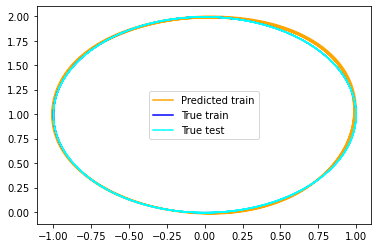

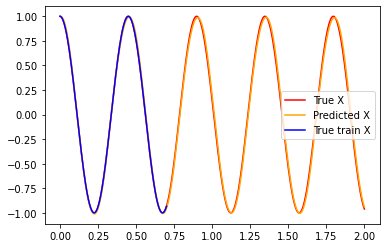

In [291]:
with torch.no_grad():
    times = torch.linspace(0., 2*N*dt, 2*N, dtype=torch.float64).float()
    predicted_output = model(getter.train_positions[0].unsqueeze(0).to(device), times.to(device))
    # display in orange the predicted position and in blue the true position of the training set

    plt.plot(predicted_output[:,-1,0].cpu().detach().numpy(), 
            predicted_output[:,-1,1].cpu().detach().numpy(), 'orange', label="Predicted train")

    if getter.noise > 0 and getter.noise < 1:
        plt.scatter(getter.train_positions[:,0].cpu().detach().numpy(), 
            getter.train_positions[:,1].cpu().detach().numpy(), s=1, c='b', label="True train")

        plt.scatter(positions[700:,0].cpu().detach().numpy(), 
            positions[700:,1].cpu().detach().numpy(), s=1, c='cyan', label="True test")
    
    else:
        plt.plot(getter.train_positions[:,0].cpu().detach().numpy(), 
            getter.train_positions[:,1].cpu().detach().numpy(), 'b', label="True train")

        plt.plot(positions[700:,0].cpu().detach().numpy(), 
                positions[700:,1].cpu().detach().numpy(), 'cyan', label="True test")

    plt.legend()
    plt.show()

    # print the X axis over the time
    plt.plot(times, positions[:,0].cpu().detach().numpy(), 'r', label="True X")
    plt.plot(times, predicted_output[:,:,0].cpu().detach().numpy(), 'orange', label="Predicted X")
    plt.plot(getter.train_times, getter.train_positions[:,0].cpu().detach().numpy(), 'b', label="True train X")
    plt.legend()
    plt.show()

# Uniform time sampling
## First test using the converging function

In [292]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnetSimple(2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train the model

Number of parameters: 1842


/var/folders/01/nfq6qhcj2j7dqfld6ps6vhbc0000gn/T/ipykernel_4325/3464511552.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.true_positions = torch.tensor(positions, dtype=torch.float64).float()


  0%|          | 0/1000 [00:00<?, ?it/s]

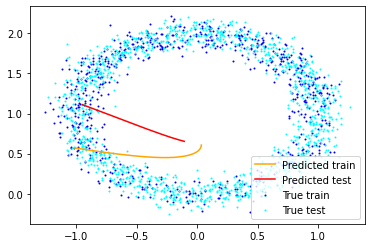

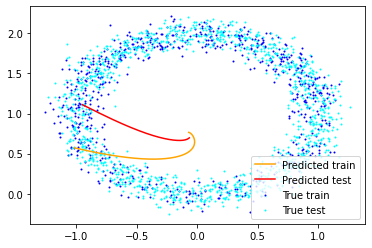

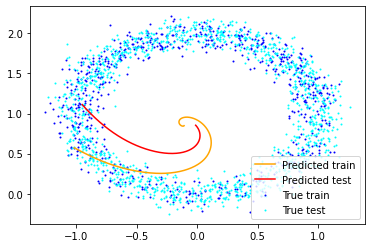

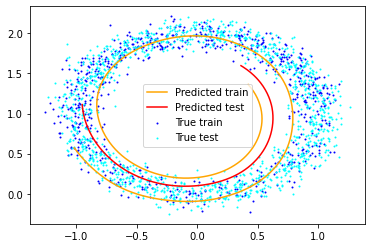

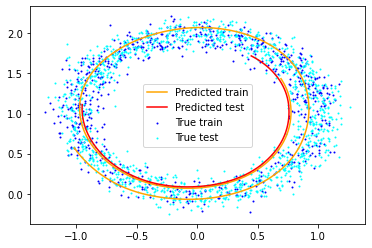

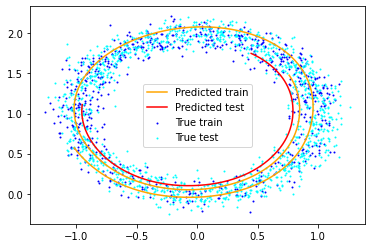

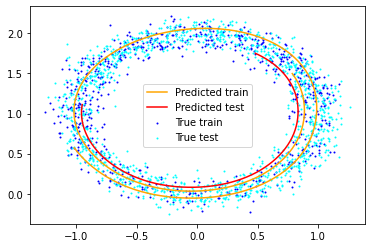

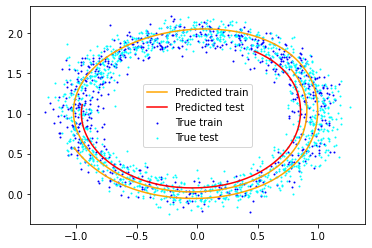

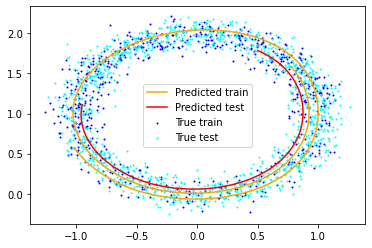

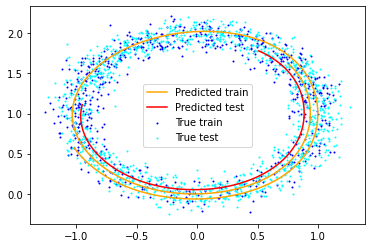

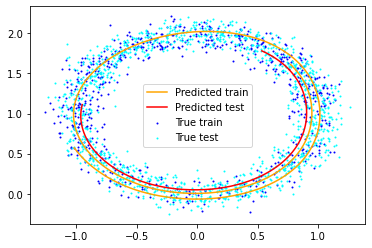

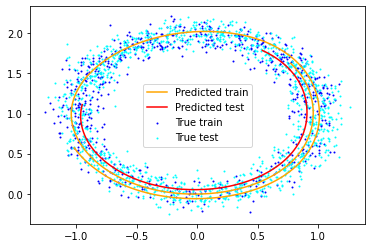

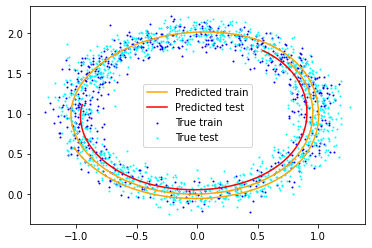

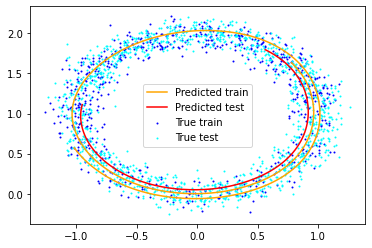

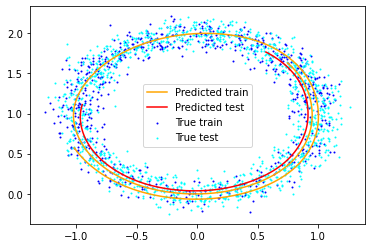

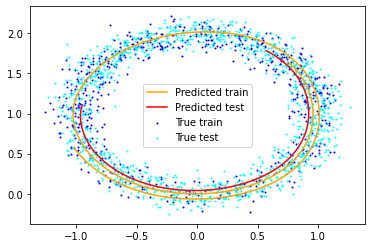

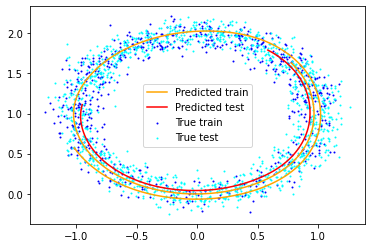

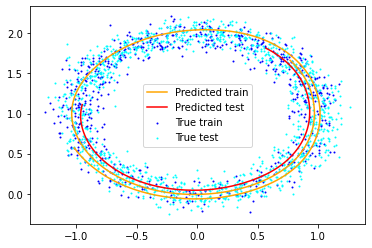

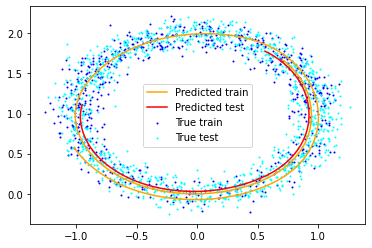

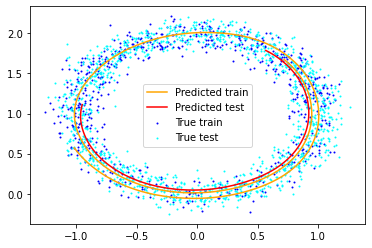

In [294]:
epochs = 1000
n_samples = 100
batch_time = 200
getter = batchGetter(batch_time=batch_time, n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=700, noise=0.1)
losses = train(model, optimizer, device, epochs, getter, display=50)

torch.Size([1000, 2])
(2000,)
(2000,)


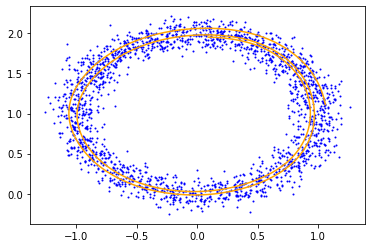

In [298]:
predicted_output = model(getter.train_positions[0].unsqueeze(0).to(device), getter.times.to(device)).squeeze()
# display in orange the predicted position and in blue the true position of the training set
# Training set
# print(predicted_output.shape)
# print(getter.true_positions[:,0].cpu().detach().numpy().shape)
# print(getter.true_positions[:,1].cpu().detach().numpy().shape)

plt.scatter(getter.true_positions[:,0].cpu().detach().numpy(), 
        getter.true_positions[:,1].cpu().detach().numpy(), s=1, c='b', label="True")

plt.plot(predicted_output[:,0].cpu().detach().numpy(), 
        predicted_output[:,1].cpu().detach().numpy(), 'orange', label="Predicted")
plt.show()

In [ ]:
epochs = 1000
n_samples = 60
getter = batchGetter(n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=800)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnet(1, 60, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train the model